In [2]:
pip install pygrib pandas geopandas scipy

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pygrib
import pandas as pd

In [14]:
import numpy as np

In [4]:
grbs = pygrib.open("CDS.grib")

In [5]:
variables_to_extract = ["2 metre temperature", 
                        "Mean total precipitation rate", 
                        "Convective available potential energy"]

In [9]:
lat_min, lat_max = -35, 14

In [10]:
# Original longitude range in -180 to 180
lon_min, lon_max = -4, 41

# Convert to 0 to 360 format
if lon_min < 0:
    lon_min += 360
if lon_max < 0:
    lon_max += 360

print(f"Converted longitude range: {lon_min} to {lon_max}")

Converted longitude range: 356 to 41


In [11]:
# Handle wrapping longitude ranges
if lon_min > lon_max:  # Check if the range crosses 0/360
    lon_range_1 = (lon_min, 360)  # First segment: 356 to 360
    lon_range_2 = (0, lon_max)    # Second segment: 0 to 41
else:
    lon_range_1 = (lon_min, lon_max)
    lon_range_2 = None  # No wrapping

print(f"Longitude segments: {lon_range_1}, {lon_range_2}")

Longitude segments: (356, 360), (0, 41)


In [8]:
all_data = pd.DataFrame()

years_to_include = [2014, 2015, 2016, 2017, 2018]

In [15]:
if lon_min > lon_max:  # Handle ranges that wrap around 0/360
    # First segment: lon_min to 360
    values1, lats1, lons1 = grb.data(lat1=lat_min, lat2=lat_max, lon1=lon_min, lon2=360)
    
    # Second segment: 0 to lon_max
    values2, lats2, lons2 = grb.data(lat1=lat_min, lat2=lat_max, lon1=0, lon2=lon_max)

    # Combine data for both segments
    values = np.concatenate((values1, values2), axis=1)
    lats = np.concatenate((lats1, lats2), axis=1)
    lons = np.concatenate((lons1, lons2), axis=1)
else:
    # Standard case: lon_min to lon_max
    values, lats, lons = grb.data(lat1=lat_min, lat2=lat_max, lon1=lon_min, lon2=lon_max)

In [16]:
# Loop through each variable
for variable in variables_to_extract:
    print(f"Processing variable: {variable}")
    # Create a DataFrame for this variable
    variable_data = pd.DataFrame()
    
    # Select messages for the current variable
    messages = grbs.select(name=variable)
    
    for grb in messages:
        # Extract the time from the GRIB message
        valid_date = grb.validDate
        year = valid_date.year
        month = valid_date.month

        # Process only the specified years
        if year in years_to_include:
            # Handle longitude conversion for 0-360 format
            if lon_min < 0:
                lon_min_360 = lon_min + 360
            else:
                lon_min_360 = lon_min

            if lon_max < 0:
                lon_max_360 = lon_max + 360
            else:
                lon_max_360 = lon_max

            # Handle wrapping longitude ranges
            if lon_min_360 > lon_max_360:  # Wrapping case
                # First segment: lon_min to 360
                values1, lats1, lons1 = grb.data(lat1=lat_min, lat2=lat_max, lon1=lon_min_360, lon2=360)
                
                # Second segment: 0 to lon_max
                values2, lats2, lons2 = grb.data(lat1=lat_min, lat2=lat_max, lon1=0, lon2=lon_max_360)

                # Combine data for both segments
                values = np.concatenate((values1, values2), axis=1)
                lats = np.concatenate((lats1, lats2), axis=1)
                lons = np.concatenate((lons1, lons2), axis=1)
            else:
                # Standard case: lon_min to lon_max
                values, lats, lons = grb.data(lat1=lat_min, lat2=lat_max, lon1=lon_min_360, lon2=lon_max_360)

            # Flatten the data and create a DataFrame
            df = pd.DataFrame({
                "latitude": lats.flatten(),
                "longitude": lons.flatten(),
                variable: values.flatten(),
                "year": year,
                "month": month
            })

            # Append to the variable-specific DataFrame
            variable_data = pd.concat([variable_data, df], ignore_index=True)

    # Save this variable's data to a separate CSV file
    filename = f"{variable.replace(' ', '_').lower()}_2014_to_2018.csv"
    variable_data.to_csv(filename, index=False)
    print(f"Saved {variable} data to {filename}")

print("Processing complete!")

Processing variable: 2 metre temperature
Saved 2 metre temperature data to 2_metre_temperature_2014_to_2018.csv
Processing variable: Mean total precipitation rate
Saved Mean total precipitation rate data to mean_total_precipitation_rate_2014_to_2018.csv
Processing variable: Convective available potential energy
Saved Convective available potential energy data to convective_available_potential_energy_2014_to_2018.csv
Processing complete!


In [2]:
import pandas as pd

# Path to your CSV file
file_path = "/Users/lenawisniewska/Desktop/Diss/IV data/2_metre_temperature_2014_to_2018.csv"

# Load the CSV file
df = pd.read_csv(file_path)

# Print the first few rows to inspect the structure
print(df.head())

# Print the column names to verify
print("Column names in the file:")
print(df.columns)


   latitude  longitude  2 metre temperature  year  month
0      14.0     356.00           298.855316  2014      1
1      14.0     356.25           297.896332  2014      1
2      14.0     356.50           297.632660  2014      1
3      14.0     356.75           297.822113  2014      1
4      14.0     357.00           297.767426  2014      1
Column names in the file:
Index(['latitude', 'longitude', '2 metre temperature', 'year', 'month'], dtype='object')


In [3]:
# Rename the column for easier access
df.rename(columns={"2 metre temperature": "temperature"}, inplace=True)

# Print to confirm renaming
print(df.columns)

Index(['latitude', 'longitude', 'temperature', 'year', 'month'], dtype='object')


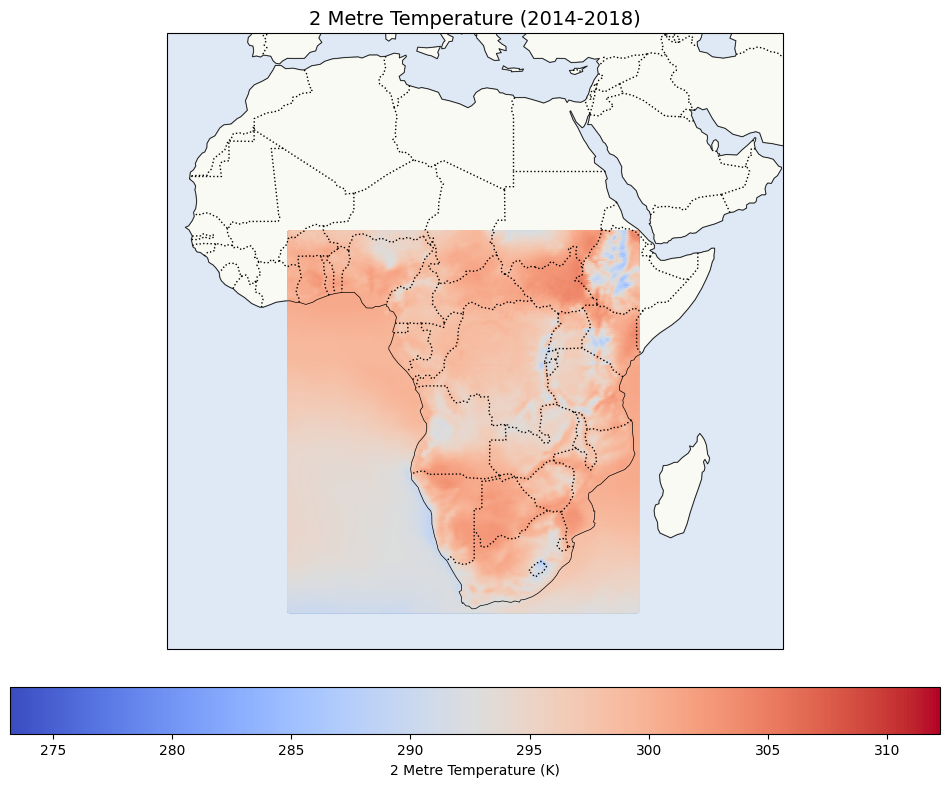

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a figure with a map projection
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())  # Use PlateCarree for longitude/latitude plotting

# Add features to the map
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.LAND, edgecolor='black', alpha=0.3)
ax.add_feature(cfeature.OCEAN, alpha=0.3)
ax.set_extent([-20, 60, -40, 40], crs=ccrs.PlateCarree())  # Focus on Africa

# Plot the temperature data
sc = plt.scatter(
    df['longitude'], 
    df['latitude'], 
    c=df['temperature'],  # Use the renamed column
    cmap='coolwarm',  # Color map
    s=10,  # Marker size
    transform=ccrs.PlateCarree()  # Transform points to PlateCarree
)

# Add colorbar for temperature
cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label('2 Metre Temperature (K)')

# Add title
plt.title('2 Metre Temperature (2014-2018)', fontsize=14)

# Show the plot
plt.show()